In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from plots import *

# **Rethinking the Training Loop**

In [2]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation.py

# Runs the first two parts of the sequence: data preparation and model configuration
%run -i data_preparation.py
%run -i model_configuration.py

In [3]:
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes our model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "a" and "b" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and the learning rate
    optimizer.step()
    optimizer.zero_grad()

In [4]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')),
             ('0.bias', tensor([1.0235], device='cuda:0'))])

## **High Order Functions**

In [5]:
def square(x):
    return x ** 2

def cube(x):
    return x ** 3

def fourth_power(x):
    return x ** 4

In [6]:
def generic_exponentiation(x, exponent):
    return x ** exponent

In [7]:
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
        return x ** exponent
    return skeleton_exponentiation

In [8]:
returned_function = exponentiation_builder(2)

returned_function

<function __main__.exponentiation_builder.<locals>.skeleton_exponentiation(x)>

In [9]:
returned_function(5)

25

In [10]:
square = exponentiation_builder(2)
cube = exponentiation_builder(3)
fourth_power = exponentiation_builder(4)

In [11]:
print(square(5))
print(cube(5))
print(fourth_power(5))

25
125
625


# **Helper Function**

In [12]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "a" and "b" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

In [13]:
%run -i data_preparation.py

In [14]:
%%writefile model_configuration_v1.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

Writing model_configuration_v1.py


In [15]:
%run -i model_configuration_v1.py

In [16]:
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step_fn(x, y)>

In [17]:
%%writefile model_training_v1.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step_fn(x_train_tensor, y_train_tensor)
    losses.append(loss)

Writing model_training_v1.py


In [19]:
%run -i model_training_v1.py

In [20]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')),
             ('0.bias', tensor([1.0235], device='cuda:0'))])

# **Dataset**

In [21]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


In [22]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


# **DataLoader**

In [23]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [24]:
next(iter(train_loader))

[tensor([[0.2809],
         [0.3253],
         [0.1560],
         [0.5924],
         [0.0651],
         [0.8872],
         [0.4938],
         [0.0055],
         [0.1409],
         [0.0885],
         [0.1849],
         [0.7290],
         [0.8662],
         [0.3117],
         [0.6842],
         [0.1987]]),
 tensor([[1.5846],
         [1.8057],
         [1.2901],
         [2.1687],
         [1.1559],
         [2.8708],
         [1.9060],
         [1.0632],
         [1.1211],
         [1.0708],
         [1.5888],
         [2.4927],
         [2.6805],
         [1.7637],
         [2.3492],
         [1.2654]])]

In [25]:
%%writefile data_preparation_v1.py

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Writing data_preparation_v1.py


In [26]:
%run -i data_preparation_v1.py

In [27]:
%run -i model_configuration_v1.py

In [29]:
%%writefile model_training_v2.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # Performs one train step and returns the corresponding loss 
        # for this mini-batch
        mini_batch_loss = train_step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    # Computes average loss over all mini-batches - that's the epoch loss
    loss = np.mean(mini_batch_losses)
    
    losses.append(loss)

Writing model_training_v2.py


In [30]:
%run -i model_training_v2.py

In [31]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')),
             ('0.bias', tensor([1.0243], device='cuda:0'))])

## **Mini-Batch Inner Loop**

In [32]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

In [33]:
%run -i data_preparation_v1.py
%run -i model_configuration_v1.py

In [34]:
%%writefile model_training_v3.py

# Defines number of epochs
n_epochs = 200

losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

Writing model_training_v3.py


In [35]:
%run -i model_training_v3.py

In [36]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9684]], device='cuda:0')),
             ('0.bias', tensor([1.0219], device='cuda:0'))])

In [37]:
%%writefile data_preparation_v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Writing data_preparation_v2.py


In [38]:
%run -i data_preparation_v2.py

## **Evaluation**

In [39]:
def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

In [40]:
%%writefile model_configuration_v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

Writing model_configuration_v2.py


In [41]:
%run -i model_configuration_v2.py

In [42]:
%%writefile model_training_v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss) 

Writing model_training_v4.py


In [43]:
%run -i model_training_v4.py

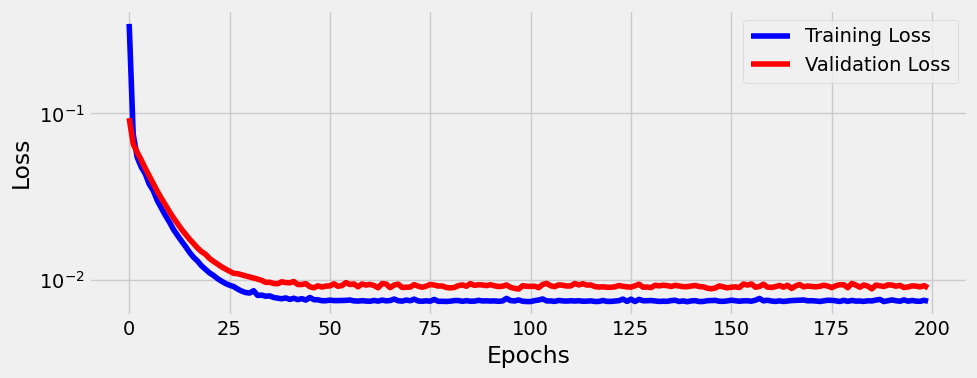

In [44]:
fig = plot_losses(losses, val_losses)

In [46]:
IS_BINDER = False
if IS_BINDER:
    display(TB_LINK)
else:
    %load_ext tensorboard
    %tensorboard --logdir runs

In [47]:
writer = SummaryWriter('runs/test')

In [49]:
# Fetching a tuple of feature (sample_x) and label (sample_y)
sample_x, sample_y = next(iter(train_loader))

# Since our model was sent to device, we need to do the same with the data
# Even here, both model and data need to be on the same device!
writer.add_graph(model, sample_x.to(device))

In [50]:
writer.add_scalars('loss', {'training': loss, 'validation': val_loss}, epoch)

In [51]:
%run -i data_preparation_v2.py

In [53]:
%%writefile model_configuration_v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

Writing model_configuration_v3.py


In [54]:
%run -i model_configuration_v3.py

In [55]:
%%writefile model_training_v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

Writing model_training_v5.py


In [56]:
%run -i model_training_v5.py

In [57]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

In [58]:
%run -i data_preparation_v2.py
%run -i model_configuration_v3.py

In [59]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

model.train()

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [60]:
%run -i model_training_v5.py

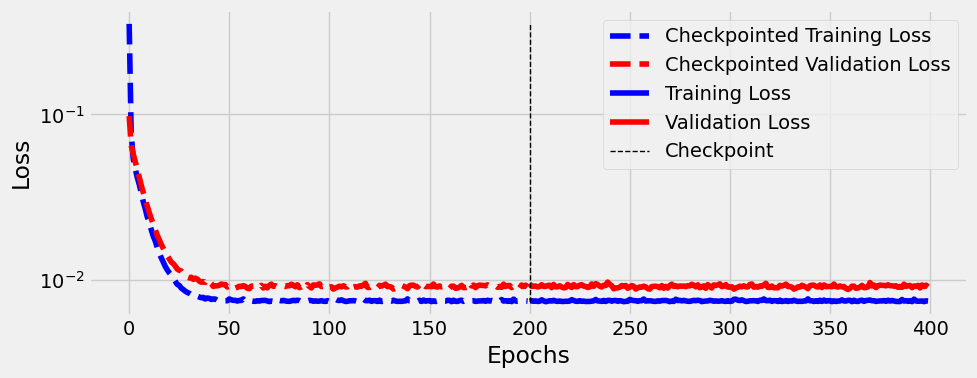

In [61]:
fig = plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses)

## **Deploying / Making Predictions**

In [62]:
%run -i model_configuration_v3.py

In [63]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [64]:
new_inputs = torch.tensor([[.20], [.34], [.57]])

model.eval() # always use EVAL for fully trained models!
model(new_inputs.to(device))

tensor([[1.4150],
        [1.6870],
        [2.1340]], device='cuda:0', grad_fn=<AddmmBackward0>)

# **Putting It All Together**

In [65]:
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

In [67]:
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

In [68]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [69]:
import shutil

shutil.rmtree('./runs/simple_linear_regression/', ignore_errors=True)